## Example using TD3 to learn a policy

This notebook illustrates how to use TD3 to learn a policy for a simple `ElectricGridEnv`. The environment is the same as the one used in [RL_Complex_external_agent](RL_Complex_external_agent.ipynb).

In [6]:
using ElectricGrid
using ReinforcementLearning
using Flux
using Flux.Losses
using StableRNGs
using IntervalSets
using Zygote: ignore
using Logging

In [7]:
# using the same environment configuration 
CM = [ 
    0. 0. 1.
    0. 0. 2.
   -1. -2. 0.
]

R_load, L_load, _, _ = ParallelLoadImpedance(50e3, 0.95, 230)

parameters = Dict{Any, Any}(
                    "source" => Any[
                                    Dict{Any, Any}(
                                        "pwr" => 200e3,
                                        "control_type" => "RL",
                                        "mode" => "my_agent",
                                        "fltr" => "L",
                                        #"L1" => 0.0008,
                                        ),
                                    Dict{Any, Any}(
                                        "pwr" => 200e3,
                                        "fltr" => "LC",
                                        "control_type" => "classic",
                                        "mode" => "Droop",),
                                    ],
                    "grid" => Dict{Any, Any}(
                        "phase" => 3,
                        "ramp_end" => 0.04,)
    )


function reference(t)
    if t < 0.04
        return [0.0, 0.0, 0.0]
    end

    θ = 2*pi*50*t
    θph = [θ; θ - 120π/180; θ + 120π/180]
    return +10 * cos.(θph) 
end


featurize_ddpg = function(state, env, name)
    if name == "my_agent"
        norm_ref = env.nc.parameters["source"][1]["i_limit"]
        state = vcat(state, reference(env.t)/norm_ref)
    end
end


function reward_function(env, name = nothing)
    if name == "classic"
        return 0        
    else
        state_to_control_1 = env.state[findfirst(x -> x == "source1_i_L1_a", env.state_ids)]
        state_to_control_2 = env.state[findfirst(x -> x == "source1_i_L1_b", env.state_ids)]
        state_to_control_3 = env.state[findfirst(x -> x == "source1_i_L1_c", env.state_ids)]

        state_to_control = [state_to_control_1, state_to_control_2, state_to_control_3]

        if any(abs.(state_to_control).>1)
            return -1
        else

            refs = reference(env.t)
            norm_ref = env.nc.parameters["source"][1]["i_limit"]          
            r = 1-1/3*(sum((abs.(refs/norm_ref - state_to_control)/2).^0.5))
            return r 
        end
    end

end


env = ElectricGridEnv(
    #CM =  CM,
    parameters = parameters,
    t_end = 1,
    reward_function = reward_function,
    featurize = featurize_ddpg,
    action_delay = 0,
    verbosity = 0
);

We have slightly modified the original TD3 implementation in Julia to make it compatible with the `ElectricGrid.jl` framework.  

Details about the TD3 algorithm can be found in the paper [Addressing Function Approximation Error in Actor-Critic Methods](https://arxiv.org/abs/1802.09477) and the original implementation in Julia can be found [here](https://github.com/JuliaReinforcementLearning/ReinforcementLearning.jl/blob/2e1de3e5b6b8224f50b3d11bba7e1d2d72c6ef7c/src/ReinforcementLearningZoo/src/algorithms/policy_gradient/td3.jl).

In [8]:
rng = StableRNG(0)
init = glorot_uniform(rng)

# specify number of states and actions to be controlled by the agent
ns = length(ElectricGrid.state(env, "my_agent"))
na = length(env.agent_dict["my_agent"]["action_ids"])

CreateActor() = Chain(
    Dense(ns, 32, relu; init = init),
    Dense(32, 32, relu; init = init),
    Dense(32, na, tanh; init = init)
)

CreateCriticModel() = Chain(
    Dense(ns + na, 64, relu; init = init),
    Dense(64, 64, relu; init = init),
    Dense(64, 1; init = init)
)


# create twin critic models
CreateCritic() = ElectricGrid.TD3Critic(
    CreateCriticModel(),
    CreateCriticModel(),
)

learning_rate = 3e-5

TD3_agent = Agent(
    policy = ElectricGrid.TD3Policy(
        behavior_actor = NeuralNetworkApproximator(
            model = CreateActor(),
            optimizer = ADAM(learning_rate),
        ),
        behavior_critic = NeuralNetworkApproximator(
            model = CreateCritic(),
            optimizer = ADAM(learning_rate),
        ),
        target_actor = NeuralNetworkApproximator(
            model = CreateActor(),
            optimizer = ADAM(learning_rate),
        ),
        target_critic = NeuralNetworkApproximator(
            model = CreateCritic(),
            optimizer = ADAM(learning_rate),
        ),
        γ = 0.99f0,
        ρ = 0.995f0,
        batch_size = 64,
        start_steps = 10,
        # start_steps = -1,
        start_policy = RandomPolicy(-1.0..1.0; rng = rng),
        update_after = 10,
        update_freq = 1,
        policy_freq = 2,
        target_act_limit = 1.0,
        target_act_noise = 0.1,
        act_limit = 1.0,
        act_noise = 0.05,
        rng = rng,
    ),

    trajectory = CircularArraySARTTrajectory(
            capacity = 10_000,
            state = Vector{Float32} => (ns,),
            action = Float32 => (na, ),
    ),
);

In [14]:
td3_agent = Dict("my_agent" => TD3_agent)

controllers = SetupAgents(env, td3_agent)

Learn(
    controllers,
    env, 
    num_episodes = 500,
);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


                 ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀         
                 ┌────────────────────────────────────────┐         
         5.84811 │⣠⣇⣇⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ classic 
                 │⠀⠀⠀⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠋⠋⠛⠙⠛⠋⠛⠛⠛⠛⠛⠛⠛⠛⠓⠓⠛⠓⠛⠒⠚⠛⠛⠛⠛│ my_agent
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
   Score         │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

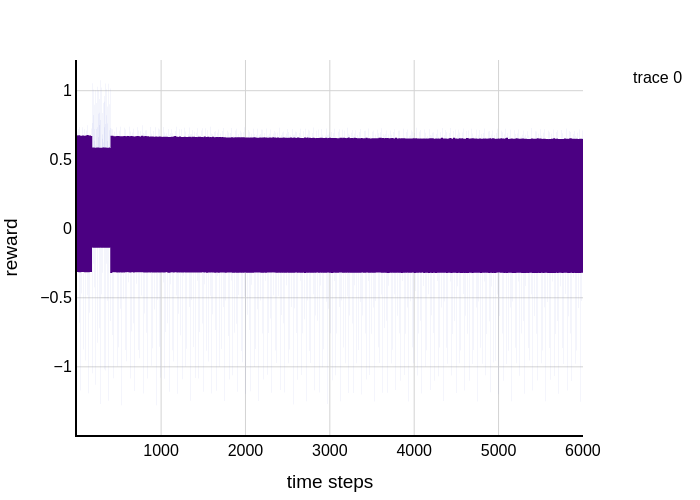

In [15]:
plot_rewardresults(controllers = controllers)

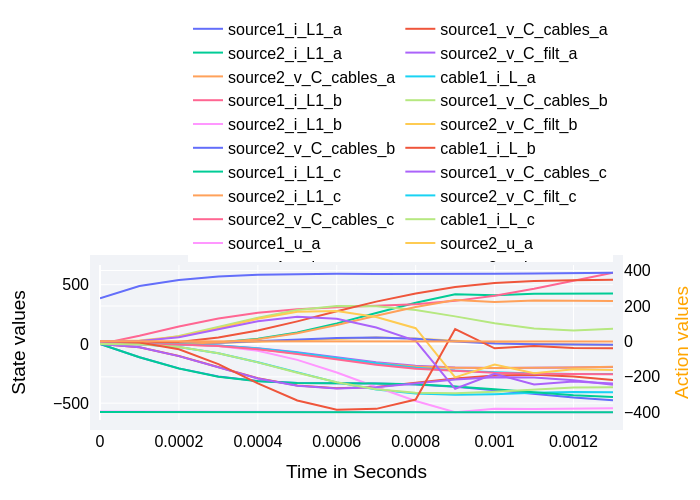

In [16]:
hook = DataHook(collect_state_ids = env.state_ids,
                collect_action_ids = env.action_ids)

hook = Simulate(controllers, env, hook=hook)

RenderHookResults(
    hook = hook,
    states_to_plot  = env.state_ids,
    actions_to_plot = env.action_ids,
    plot_reward=true
)